We import the main libraries we will be working with.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#to view pandas dataframes by scrolling horizontally
pd.options.display.max_columns = None

We import the week dataset file and save it in the **week_data** dataframe.

In [3]:
week_data = pd.read_csv("../raw_data/1_week_RAW.csv")

week_data.head()

,datetime,x_D,y_D,z_D,x_ND,y_ND,z_ND
0,2017-05-04 00:00:00.000000,-0.949,0.035,0.273,-0.957,0.008,0.277
1,2017-05-04 00:00:00.012500,-0.953,0.027,0.273,-0.957,0.000,0.277
2,2017-05-04 00:00:00.025000,-0.953,0.027,0.266,-0.961,0.000,0.270
3,2017-05-04 00:00:00.037500,-0.949,0.023,0.266,-0.957,0.000,0.273
4,2017-05-04 00:00:00.050000,-0.949,0.023,0.270,-0.957,-0.004,0.273


We use the **info()** function of pandas to get the information about all the columns in the dataframe.

In [36]:
week_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41472000 entries, 0 to 41471999
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   datetime  object 
 1   x_D       float64
 2   y_D       float64
 3   z_D       float64
 4   x_ND      float64
 5   y_ND      float64
 6   z_ND      float64
dtypes: float64(6), object(1)
memory usage: 2.2+ GB


We transform the *datetime* column from object to datetime so that we can more easily deal with this data through functions that already exist in pandas.

In [4]:
week_data['datetime'] = pd.to_datetime(week_data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

week_data["datetime"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 41472000 entries, 0 to 41471999
Series name: datetime
Non-Null Count     Dtype         
--------------     -----         
41472000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 316.4 MB


We compute the **magnitude** for both the dominant and non dominant hand.

In [5]:
week_data['magnitude_D'] = np.sqrt(week_data['x_D']**2 + week_data['y_D']**2 + week_data['z_D']**2)
week_data['magnitude_ND'] = np.sqrt(week_data['x_ND']**2 + week_data['y_ND']**2 + week_data['z_ND']**2)

We compute the **asimettry index** using this formula:

$$ \frac{\text{magnitude}_\text{D} - \text{magnitude}_{\text{ND}}}{\text{magnitude}_\text{D} + \text{magnitude}_{\text{ND}}} \cdot 100$$

In [6]:
week_data["AI"]=(((week_data['magnitude_D'] - week_data['magnitude_ND']) / (week_data['magnitude_D'] + week_data['magnitude_ND'])) * 100).fillna(0)

We split *datetime* column in three new columns: *year*, *month*, *day*.

In [7]:
week_data['year'] = week_data['datetime'].dt.year
week_data['month'] = week_data['datetime'].dt.month
week_data['day'] = week_data['datetime'].dt.day

We resort the columns of the dataframe. In this way we have a clearer dataframe that reports the most important information at the beginning.

In [8]:
new_order=['datetime', 'year', 'month', 'day', 'AI', 'magnitude_D', 'magnitude_ND', 'x_D', 'y_D', 'z_D', 'x_ND', 'y_ND', 'z_ND']

week_data=week_data[new_order]

week_data.head()

,datetime,year,month,day,AI,magnitude_D,magnitude_ND,x_D,y_D,z_D,x_ND,y_ND,z_ND
0,2017-05-04 00:00:00.000000,2017,5,4,-0.413593,0.988107,0.996314,-0.949,0.035,0.273,-0.957,0.008,0.277
1,2017-05-04 00:00:00.012500,2017,5,4,-0.230537,0.991699,0.996282,-0.953,0.027,0.273,-0.957,0.000,0.277
2,2017-05-04 00:00:00.025000,2017,5,4,-0.423237,0.989795,0.998209,-0.953,0.027,0.266,-0.961,0.000,0.270
3,2017-05-04 00:00:00.037500,2017,5,4,-0.471201,0.985843,0.995177,-0.949,0.023,0.266,-0.957,0.000,0.273
4,2017-05-04 00:00:00.050000,2017,5,4,-0.416516,0.986930,0.995185,-0.949,0.023,0.270,-0.957,-0.004,0.273


## Semaphore index

At this point we would like to find an index for the semaphore. Our idea follows roughly along these lines. First we calculate the median of the asymmetry index over the six days - which in this case we assume to be our training set, but later we will justify the operation better. Once this median is calculated we use it as a reference. In fact this median would be the **expected asymmetry index** that we expect to find in the patient. At this point, for each day - of course we assume we are working over a much wider time range than 6 days - we compute the average of the patient's asymmetry index and compare it to the median. If it deviates too much, the semaphore light will be red. If it deviates, but within a certain range, the semaphore light will be orange. If it is very close to the expected value, the semaphore light will be green. 

Before explaining in detail how this range works, let us go through a clarification. The median that we calculate below we assume we have a priori - like the AHA, the expected asymmetry index of each patient will be entered in the table found in **metadata2022_o04**, so there will be no need to calculate it. The fact that we calculate the median over all the data should therefore not frighten us; we are simply assuming that this is our baseline for a much larger work - whose data we clearly do not have, but in which the code works just fine.

In [44]:
median=week_data['AI'].median()

print(median)

-0.020795431128620073


To get a sense of how our code will then work and how the ranges will be defined let us then do a simulation. So we first compute the mean of the asimmetry index for each day and save it in a new dataframe called **week_data_by_day**.

In [9]:
week_data_by_day=week_data.groupby(['year', 'month', 'day']).agg({
    'AI' : 'mean'
}).reset_index()

week_data_by_day

,year,month,day,AI
0,2017,5,4,0.853767
1,2017,5,5,-0.411470
2,2017,5,6,-0.041722
3,2017,5,7,-0.177609
4,2017,5,8,0.021350
5,2017,5,9,-0.219281


At this point we move on to print the **box plot** which allows us to show graphically how the outliers will be detected and thus the semaphore index values. In general, the box plot shows the following:

- **Quartiles and Median**: The center rectangle of the box plot represents the middle 50% of the data and is divided into two equal parts by quartiles Q1 and Q3. The line inside the rectangle represents the median (Q2) - the one calculated above - which is the value separating the bottom 50% from the top 50% of the data.
- **Whiskers**: Whiskers extend from the quartiles to the minimum and maximum observations that fall within a certain distance of the quartiles. Whisker length is often calculated as 1.5 times the interquartile range (IQR), which is the difference between the first and third quartiles (IQR = Q3 - Q1). 
- **Outliers**: Points identified outside the whiskers are considered outliers and are represented as individual points.
- **General Appearance**: Box plots provide insight into the distribution of the data, highlighting the presence of outliers and providing an idea of the symmetry of the distribution.

In our case, therefore, we will do the following:
- First we print both the points that fall outside the whiskers and the points that fall inside the whiskers but outside the box.
- If the dots fall outside the whiskers these are outliers. On days when this happens so we say that our semaphore will be red.
- Instead, if the points fall inside the whiskers but outside the box we will say that these are data that deviate from the median but not too much. On days when this happens we then say that our semaphore will be orange.
- Finally, if the points fall inside the box these are clearly very close to the expected asymmetry index. On days when this happens so we set the semaphore as green.

We then note that the whiskers are used to compute the range that allows us to understand whether the points that differ from the median are not far enough away to be called outliers - and thus to set the semaphore red. We conclude by saying that these operations done through the **seaborn** library can be calculated simply using the basic operations, and that the use of this library is for visual purposes only. 

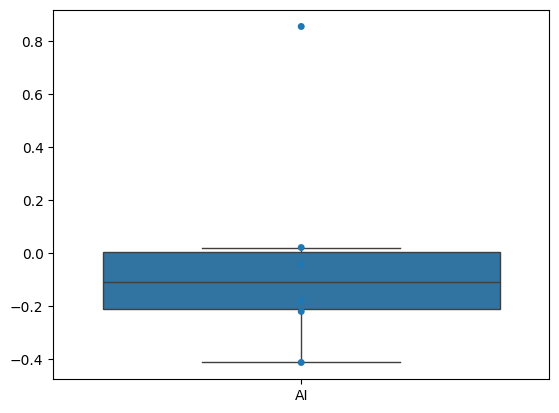

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_of_interest = ['AI']
data_to_plot = week_data_by_day[columns_of_interest]

# Crea un box plot con solo i punti che cadono all'interno dei whiskers ma fuori dal box
ax = sns.boxplot(data=data_to_plot, whis=1.5, showfliers=False)

# Aggiungi i punti come punti separati sullo stesso grafico, solo quelli all'interno dei whiskers
sns.swarmplot(data=data_to_plot, ax=ax, dodge=True)

# Mostra il grafico
plt.show()
